# Final model

### Libraries import

In [1]:
import pandas as pd
import numpy as np

#model
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

#Hyperopt
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#visualization
from scikitplot.estimators import plot_learning_curve
import matplotlib.pyplot as plt

### Data import

In [2]:
df_train = pd.read_csv("../output/post_fe_train_data.csv")
df_test = pd.read_csv("../output/post_fe_test_data.csv")

df = pd.concat([df_train, df_test])
print(df.shape, df.shape)

(34180, 151) (34180, 151)


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option("max_info_columns", 300)

### Model check function

In [4]:
def check_log_model(df, feats, model, cv=5, scoring="neg_mean_absolute_error"):
    df_train = df[ ~df["price"].isnull() ].copy()

    X = df_train[feats]
    y = df_train["price"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]

        #model = xgb.XGBRegressor(max_depth=8, n_estimators=700, learning_rate=0.1, random_state=0)
        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)

        score = mean_absolute_error(y_test, y_pred)
        scores.append(score)
        
    return np.mean(scores), np.std(scores)

### Let's try with all the variables 

In [5]:
black_list = ['price', 'price_log', 'id']
feats = df.select_dtypes(include=[np.number, np.bool]).columns
feats = [feat for feat in feats if feat not in black_list]

In [6]:
check_log_model(df, feats, xgb.XGBRegressor(max_depth=8, n_estimators=700, learning_rate=0.1, random_state=0))

(2.6075845777413322, 0.31007420115400947)

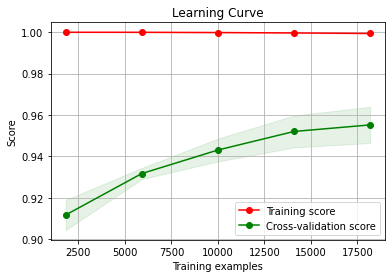

In [7]:
df_train = df[ ~df["price"].isnull() ].copy()

X = df_train[feats]
y = df_train["price"]
y_log = np.log(y)

plot_learning_curve(xgb.XGBRegressor(max_depth=8, n_estimators=700, learning_rate=0.1, random_state=0), X, y_log, cv=5);

### Features selected to be checked 

We discard variables with a large number of missing values

In [18]:
feats = [
#    'Number of buildings:',
    'Number of rooms:',
#    'Number of apartments:',
    'Year built:',
#    'Number of entrances:',
#    'Number of dwellings:',
#    'The largest number of floors:',
#    'The smallest number of floors:',
#    'kitchen_area',
#    'ceiling_height',
#    'living_room',
    'offer_views',
    'floor',
#    'elite_class',
#    'security_true',
#    'parking_true',
#    'no_fee_true',
#    'new_building_true',
    'kitchen_area_log',
    'ceiling_height_log',
#    'living_room_log',
#    'offer_views_log',
#    'Security:_cat',
#    'Building type:_cat',
#    'Object type:_cat',
    'Ad type:_cat',
    'Developer:_cat',
#    'Date published:_cat',
#    'Parking:_cat',
#    'Updated date:_cat',
#    'Commission agent:_cat',
    'Construction phase:_cat',
#    'New building:_cat',
    'Housing class:_cat',
    'Elevator:_cat',
    'The view from the window:_cat',
    'Mortgage possible:_cat',
    'Garbage chute:_cat',
    'Repair:_cat',
    'Bathroom type:_cat',
    'Balcony type:_cat',
#    'Kitchen furniture:_cat',
#    'Fridge:_cat',
#    'Internet:_cat',
#    'Furniture:_cat',
#    'Phone:_cat',
#    'Free layout:_cat',
#    'Management company:_cat',
#    'Type of the building:_cat',
#    'Room type:_cat',
#    'Floor covering:_cat',
#    'Series:_cat',
#    'Overlap type:_cat',
#    'It is possible to bargain:_cat',
#    'Class:_cat',
#    'TV:_cat',
#    'Foundation type:_cat',
#    'Playground:_cat',
#    'Washing machine:_cat',
    'block_user_name_cat',
    'block_user_agency_cat',
    'street_cat',
    'subway_cat',
    'MCC_cat',
    'New_Moscow_cat',
    'village_cat'
]

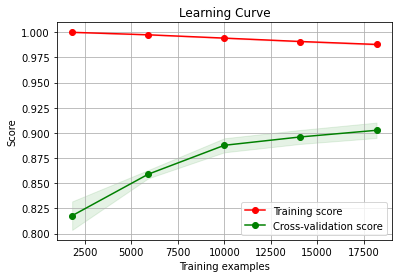

In [21]:
df_train = df[ ~df["price"].isnull() ].copy()

X = df_train[feats]
y = df_train["price"]
y_log = np.log(y)

plot_learning_curve(xgb.XGBRegressor(max_depth=8, n_estimators=700, learning_rate=0.1, random_state=0), X, y_log, cv=5);

In [9]:
len(feats)

24

### Algorithm that selects features to the model 

The algorithm is checking if feature added to the model improves the result. 

In [10]:
feats_to_go = [
    'area_log'
]
basic_model_result = check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=5, n_estimators=100, random_state=0))
basic_mean_result = basic_model_result[0]
best_result = basic_mean_result

In [11]:
for i in tqdm(range(25)):
    mean_result = []
    for i in range(len(feats)):
        feats_to_go.append(feats[i])
        model_result = check_log_model(df, feats_to_go, xgb.XGBRegressor(max_depth=5, n_estimators=100, random_state=0))
        mean_result.append(model_result[0])
        del feats_to_go[-1]
    if min(mean_result) > best_result:
        break
    else: best_result = min(mean_result)
    best_value_index = np.argmin(mean_result)
    feats_to_go.append(feats[best_value_index]) 
    del feats[best_value_index]
    print(feats_to_go)
    print(best_result)

  4%|███▎                                                                               | 1/25 [01:06<26:42, 66.78s/it]

['area_log', 'MCC_cat']
4.40567224629253


  8%|██████▋                                                                            | 2/25 [02:14<25:42, 67.07s/it]

['area_log', 'MCC_cat', 'Developer:_cat']
3.501406300873614


 12%|█████████▉                                                                         | 3/25 [03:18<24:12, 66.04s/it]

['area_log', 'MCC_cat', 'Developer:_cat', 'Housing class:_cat']
3.1499629646619036


 16%|█████████████▎                                                                     | 4/25 [04:18<22:28, 64.20s/it]

['area_log', 'MCC_cat', 'Developer:_cat', 'Housing class:_cat', 'floor']
3.0352426800147185


 20%|████████████████▌                                                                  | 5/25 [05:16<20:48, 62.45s/it]

['area_log', 'MCC_cat', 'Developer:_cat', 'Housing class:_cat', 'floor', 'New_Moscow_cat']
2.958022760718439


 24%|███████████████████▉                                                               | 6/25 [06:13<19:13, 60.70s/it]

['area_log', 'MCC_cat', 'Developer:_cat', 'Housing class:_cat', 'floor', 'New_Moscow_cat', 'Construction phase:_cat']
2.9252612761518844


 28%|███████████████████████▏                                                           | 7/25 [07:08<17:45, 59.17s/it]

['area_log', 'MCC_cat', 'Developer:_cat', 'Housing class:_cat', 'floor', 'New_Moscow_cat', 'Construction phase:_cat', 'Year built:']
2.8550208458756696


 32%|██████████████████████████▌                                                        | 8/25 [08:02<16:18, 57.54s/it]

['area_log', 'MCC_cat', 'Developer:_cat', 'Housing class:_cat', 'floor', 'New_Moscow_cat', 'Construction phase:_cat', 'Year built:', 'street_cat']
2.8327844944066736


 36%|█████████████████████████████▉                                                     | 9/25 [08:52<14:45, 55.36s/it]

['area_log', 'MCC_cat', 'Developer:_cat', 'Housing class:_cat', 'floor', 'New_Moscow_cat', 'Construction phase:_cat', 'Year built:', 'street_cat', 'Garbage chute:_cat']
2.8136078560453726


 36%|█████████████████████████████▉                                                     | 9/25 [09:41<17:14, 64.66s/it]


In [12]:
feats_to_go

['area_log',
 'MCC_cat',
 'Developer:_cat',
 'Housing class:_cat',
 'floor',
 'New_Moscow_cat',
 'Construction phase:_cat',
 'Year built:',
 'street_cat',
 'Garbage chute:_cat']

### HyperOpt

In [13]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'seed': 2021, #int(space['seed']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': int(space['n_estimators']),
        'objective': 'reg:squarederror',
    }
    
    print(xgb_params)
    
    mean_score, std_score = check_log_model(df, feats_to_go, xgb.XGBRegressor(**xgb_params))
    
    print("score:", mean_score, std_score)
    
    return{'loss':mean_score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 5, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.2, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.05, 0.2),
    'subsample': hp.uniform ('x_subsample', 0.6, 1.),
    'seed': hp.quniform ('x_seed', 0, 10000, 50),
    'min_child_weight': hp.quniform ('x_min_child_weight', 10, 200, 10),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
    'n_estimators': hp.quniform ('x_n_estimators', 500, 1300, 50),
    'shift': hp.quniform ('x_shift', 1, 200, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=50,
            trials=trials)

print("The best params: ", best_params)

{'max_depth': 8, 'colsample_bytree': 0.7193852484626175, 'learning_rate': 0.09368891585162065, 'subsample': 0.9159026703152395, 'seed': 2021, 'min_child_weight': 140, 'reg_alpha': 1.638662169358977, 'reg_lambda': 0.749721659817257, 'n_estimators': 900, 'objective': 'reg:squarederror'}
score:                                                                                                                 
2.9914352240272697                                                                                                     
0.46265197296249966                                                                                                    
{'max_depth': 6, 'colsample_bytree': 0.7664641997291808, 'learning_rate': 0.08452052380698423, 'subsample': 0.9479689602427461, 'seed': 2021, 'min_child_weight': 150, 'reg_alpha': 1.6339885260626732, 'reg_lambda': 0.706355065756025, 'n_estimators': 900, 'objective': 'reg:squarederror'}
score:                                                             

3.028737528898594                                                                                                      
0.46588352716876824                                                                                                    
{'max_depth': 16, 'colsample_bytree': 0.579039588408167, 'learning_rate': 0.11188164723139915, 'subsample': 0.7159413721518133, 'seed': 2021, 'min_child_weight': 50, 'reg_alpha': 1.2927108341881612, 'reg_lambda': 0.7088405700586201, 'n_estimators': 700, 'objective': 'reg:squarederror'}
score:                                                                                                                 
2.809200346918491                                                                                                      
0.43236756869911297                                                                                                    
{'max_depth': 7, 'colsample_bytree': 0.35879728709576836, 'learning_rate': 0.17541076043843962, 'subsample': 0.83

score:                                                                                                                 
2.8716773195871577                                                                                                     
0.42290156244663557                                                                                                    
{'max_depth': 17, 'colsample_bytree': 0.7933473435539142, 'learning_rate': 0.07681478448489344, 'subsample': 0.8111620326520321, 'seed': 2021, 'min_child_weight': 10, 'reg_alpha': 1.7695835057717386, 'reg_lambda': 0.9632081180466946, 'n_estimators': 600, 'objective': 'reg:squarederror'}
score:                                                                                                                 
2.6980580018270786                                                                                                     
0.3737161247205634                                                                                              

{'max_depth': 12, 'colsample_bytree': 0.46979991604329596, 'learning_rate': 0.18820836718555464, 'subsample': 0.7601139678929473, 'seed': 2021, 'min_child_weight': 60, 'reg_alpha': 2.537963095823225, 'reg_lambda': 0.8488886017019042, 'n_estimators': 750, 'objective': 'reg:squarederror'}
score:                                                                                                                 
2.897051038765378                                                                                                      
0.42958932405986194                                                                                                    
{'max_depth': 17, 'colsample_bytree': 0.7688923016249414, 'learning_rate': 0.07164954264945379, 'subsample': 0.920656123548604, 'seed': 2021, 'min_child_weight': 10, 'reg_alpha': 1.5644564376402101, 'reg_lambda': 0.9315391798720303, 'n_estimators': 650, 'objective': 'reg:squarederror'}
score:                                                           

In [14]:
best_params

{'x_colsample_bytree': 0.7688923016249414,
 'x_learning_rate': 0.07164954264945379,
 'x_max_depth': 17.0,
 'x_min_child_weight': 10.0,
 'x_n_estimators': 650.0,
 'x_reg_alpha': 1.5644564376402101,
 'x_reg_lambda': 0.9315391798720303,
 'x_seed': 9200.0,
 'x_shift': 17.0,
 'x_subsample': 0.920656123548604}

### Final model learning curve

[12:56:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "x_colsample_bytree", "x_learning_rate", "x_max_depth", "x_min_child_weight", "x_n_estimators", "x_reg_alpha", "x_reg_lambda", "x_seed", "x_shift", "x_subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "x_colsample_bytree", "x_learning_rate", "x_max_depth", "x_min_child_weight", "x_n_estimators", "x_reg_alpha", "x_reg_lambda", "x_seed", "x_shift", "x_subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

[12:56:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "x_colsample_bytree", "x_learning_rate", "x_max_depth", "x_min_child_weight", "x_n_estimators", "x_reg_alpha", "x_reg_lambda", "x_seed", "x_shift", "x_subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "x_colsample_bytree", "x_learning_rate", "x_max_depth", "x_min_child_weight", "x_n_estimators", "x_reg_alpha", "x_reg_lambda", "x_seed", "x_shift", "x_subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

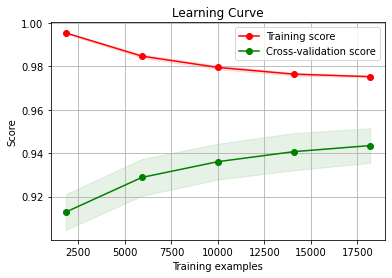

In [15]:
df_train = df[ ~df["price"].isnull() ].copy()

X = df_train[feats_to_go]
y = df_train["price"]
y_log = np.log(y)

plot_learning_curve(xgb.XGBRegressor(**best_params), X, y_log, cv=5);

In [16]:
check_log_model(df, feats_to_go, xgb.XGBRegressor(**best_params))

[12:56:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "x_colsample_bytree", "x_learning_rate", "x_max_depth", "x_min_child_weight", "x_n_estimators", "x_reg_alpha", "x_reg_lambda", "x_seed", "x_shift", "x_subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:56:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "x_colsample_bytree", "x_learning_rate", "x_max_depth", "x_min_child_weight", "x_n_estimators", "x_reg_alpha", "x_reg_lambda", "x_seed", "x_shift", "x_subsample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip

(2.7343959896407446, 0.36591098978789643)

### Kaggle submit

In [17]:
df_train = df[ ~df["price"].isnull() ].copy()
df_test = df[ df["price"].isnull() ].copy()

X_train = df_train[feats_to_go]
y_train = df_train["price"]
y_log_train = np.log(y_train)

X_test = df_test[feats_to_go]

model = xgb.XGBRegressor(max_depth=8, n_estimators=700, learning_rate=0.1, random_state=0)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)


df_test["price"] = y_pred
df_test[ ["id", "price"] ].to_csv("../output/xgb_submit.csv", index=False)